# Wind Energy Production Prediction

In this notebook, the process of coming to the final model is displayed. It will also explain why we made certain decisions.

## Importing packages 

Importing the needed packages. 

In [68]:
import numpy as np
import optuna
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import sklearn
import tensorflow as tf

from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import KFold, train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler
# from sklearn.utils import shuffle

from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Dense, Dropout, GRU, Input, LSTM, SimpleRNN
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2

print(f"numpy version: {np.__version__}")
print(f"optuna version: {optuna.__version__}")
print(f"pandas version: {pd.__version__}")
print(f"matplotlib version: {mpl.__version__}")
print(f"scikit-learn version: {sklearn.__version__}")
print(f"tensorflow version: {tf.__version__}")

numpy version: 2.0.2
optuna version: 4.1.0
pandas version: 2.2.3
matplotlib version: 3.10.0
scikit-learn version: 1.6.1
tensorflow version: 2.18.0


## Loading Data

In this section, we will load the cleaned dataset, which contains both weather data and wind energy production data. This dataset will be used for model training.

In [69]:
df = pd.read_csv('../data/Model/production_wind_data.csv')
df.sample(5)

,datetime,point,type,granularity,timezone,activity,classification,capacity,volume,percentage,...,CloudCover,RelativeAtmosphericHumidity,IndicatorWeatherCode,Fog,Rain,Snow,Thunder,IceFormation,AvgDailyTemperature,TemperatureAvgMonthlyTemperature
14582,2022-08-31 14:00:00,Nederland,Wind,Hour,UTC,Providing,Current,3694344,3694344,0.710539,...,2,39,5,0,0,0,0,0,18.354167,19.977016
32124,2021-09-01 13:00:00,Nederland,WindOffshoreC,Hour,UTC,Providing,Current,259250,259250,0.118031,...,8,69,5,0,0,0,0,0,16.504167,15.931806
41917,2022-10-14 14:00:00,Nederland,WindOffshoreC,Hour,UTC,Providing,Current,336751,336751,0.153316,...,8,87,7,0,0,0,0,0,12.562500,13.050269
48825,2023-07-29 10:00:00,Nederland,WindOffshoreC,Hour,UTC,Providing,Current,1490499,1490499,0.678595,...,8,88,7,0,1,0,0,0,18.787500,18.121371
25135,2023-11-14 07:00:00,Nederland,Wind,Hour,UTC,Providing,Current,5865251,5865251,0.960045,...,7,82,7,0,1,0,0,0,11.895833,7.799861


Since the dataset contains some offshore wind data, we will remove those entries to ensure that only mainland wind data is included. 

Offshore wind data could confuse the model since the weather data is from the center of the Netherlands(de Bilt).

In [70]:
# Select only rows where the 'type' column is 'Wind'
df = df[df['type'] == 'Wind']
df.sample(5)

,datetime,point,type,granularity,timezone,activity,classification,capacity,volume,percentage,...,CloudCover,RelativeAtmosphericHumidity,IndicatorWeatherCode,Fog,Rain,Snow,Thunder,IceFormation,AvgDailyTemperature,TemperatureAvgMonthlyTemperature
1843,2021-03-18 19:00:00,Nederland,Wind,Hour,UTC,Providing,Current,1166363,1166363,0.318114,...,8,80,5,0,0,0,0,0,4.400000,6.391667
12384,2022-06-01 00:00:00,Nederland,Wind,Hour,UTC,Providing,Current,196948,196948,0.039944,...,8,93,7,0,1,0,0,0,12.608333,17.077361
26156,2023-12-26 20:00:00,Nederland,Wind,Hour,UTC,Providing,Current,376823,376823,0.060943,...,8,97,5,0,0,0,0,0,7.608333,6.888441
9414,2022-01-28 06:00:00,Nederland,Wind,Hour,UTC,Providing,Current,1180572,1180572,0.258469,...,6,82,5,0,0,0,0,0,6.625000,5.299731
24342,2023-10-12 06:00:00,Nederland,Wind,Hour,UTC,Providing,Current,278615,278615,0.046037,...,8,98,7,0,1,0,0,0,15.450000,13.213710


## Predictions

To start the predictions phase, we will select the features that best fit the target. This way, we give the model the best chance to accurately predict the target.

### Feature Selection

In the heatmap displayed in the EDA, we identified the columns that best correlate with the target variable. These columns will be used as features in the model.

In [71]:
# # Convert 'datetime' to datetime format and set as index
# df['datetime'] = pd.to_datetime(df['datetime'])
# df.set_index('datetime', inplace=True)

# Features and target selection
features = ['WindSpeedAvg60min', 'WindGust','WindSpeedAvg10min', 'WindDirection', 'Temperature', 'Pressure']
target = 'capacity'

Next, we will be scaling the data. Scaling the data improves the stability of the training process by ensuring that the features contribute equally during training.

In [72]:
# Scale the data
feature_scaler = MinMaxScaler()
target_scaler = MinMaxScaler()

# Fit and transform features and target
scaled_features = feature_scaler.fit_transform(df[features])
scaled_target = target_scaler.fit_transform(df[[target]])

# Combine scaled features and target
scaled_data = np.hstack([scaled_features, scaled_target])


Next, we will be creating sequences. This step is crucial for time series forecasting as it allows the model to look back upon data from earlier time steps. By creating sequences, we enable the model to capture temporal dependencies and patterns in the data, which can significantly improve the accuracy of our predictions.

In this context, a sequence is a subset of the data that includes a specified number of previous time steps (e.g., the past 24 hours) to predict the next time step. This approach helps the model understand how past observations influence future values.

In [73]:
# Function to create sequences
def create_sequences(data, seq_length):
    xs, ys = [], []
    for i in range(len(data) - seq_length):
        x = data[i:i+seq_length, :-1]
        y = data[i+seq_length, -1]
        xs.append(x)
        ys.append(y)
    return np.array(xs), np.array(ys)

# Define sequence length
seq_length = 24  # Use past 24 hours to predict the next hour

# Create sequences
X, y = create_sequences(scaled_data, seq_length)

Next, we split the data into training and testing sets using an 80/20 split, where 80% of the data is used for training and 20% is used for testing. This ensures that the model has enough data to learn from while also having a separate set of data to evaluate its performance.

In [74]:
# # Shuffle the dataset
# X, y = shuffle(X, y, random_state=42)

# Split the dataset with a random state
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


### Modeling
To start of the modeling section. We decides to try a couple of different models and improve on the model with the most potential. 

#### LSTM

To start off with LSTM. LSTM stands for Long Short-Term Memory. It is a deep learning model that is comparable to an ARIMA model. While ARIMA is not suited for long-term predictions beyond 6 months, LSTM is more suited for these types of time series predictions.


In [75]:
# Build the LSTM model
model = Sequential([
    LSTM(128, return_sequences=True, input_shape=(seq_length, len(features))),
    Dropout(0.2),
    LSTM(256),
    Dropout(0.2),
    Dense(1)
])
# Compile the model
optimizer = Adam(learning_rate=0.01)
model.compile(optimizer=optimizer, loss='mse', metrics=['mae'])


c:\Users\Marjolein\Documents\GitHub\EnergieOpwek\tf_env\lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


This LSTM model has 5 layers, with the last one being an output layer.

It includes:
- 2 LSTM layers: These layers contain memory cells that allow the model to maintain information over long periods. This makes the LSTM suitable for predictions over data with seasonal trends.
- 2 Dropout layers: These layers randomly drop units during training, forcing the model to learn redundant representations. This improves the model's ability to generalize to new data and prevents overfitting.


In [76]:
# Train the model
history = model.fit(
    X_train, y_train,
    epochs=30,
    batch_size=32,
    validation_split=0.35,
    verbose=0
)

# Calculate R2 score for train data
train_predictions = model.predict(X_train)
train_r2 = r2_score(y_train, train_predictions)

# Calculate R2 score for test data
predictions = model.predict(X_test)
test_r2 = r2_score(y_test, predictions)

print(f"Train R2 Score: {train_r2}")
print(f"Test R2 Score: {test_r2}")

KeyboardInterrupt: 

The initial model performs quite well and does not appear to be overfitted. Next, we will examine the training performance over all epochs.

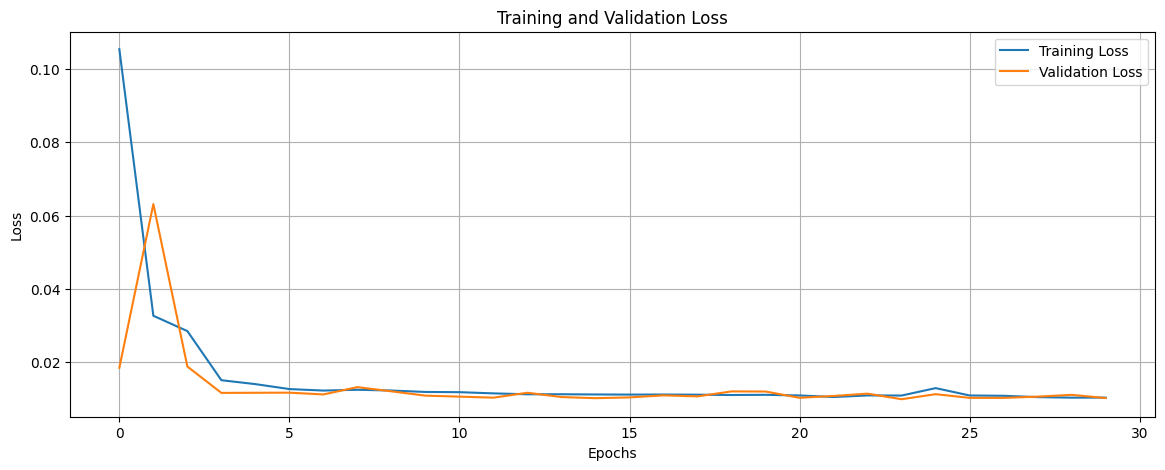

In [ ]:
# Plot training history
plt.figure(figsize=(14, 5))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

The training and validation loss curves are close to each other, indicating that the model is not overfitting and can generalize well to new data. Overfitting occurs when a model performs well on training data but poorly on validation data, typically seen when the training loss is much lower than the validation loss. In our case, the close alignment of these curves suggests that the model has learned the underlying patterns without memorizing the training data.

The use of dropout layers in the model architecture helps prevent overfitting by randomly dropping units during training, forcing the model to learn redundant representations. This improves the model's ability to generalize to new data.

Overall, the training and validation loss curves indicate that the model performs well and can generalize effectively to unseen data.

Next, we will print a plot that will show the predicte values against the actual values. 

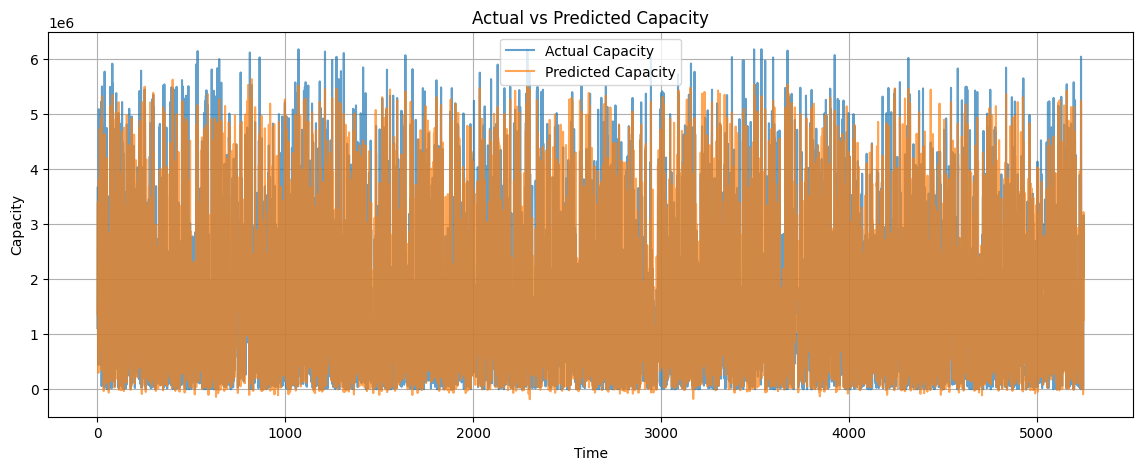

In [63]:
# Inverse transform predictions and actual values
predicted_capacity = target_scaler.inverse_transform(predictions)
actual_capacity = target_scaler.inverse_transform(y_test.reshape(-1, 1)).flatten()

# Plot Predictions vs Actual Values
plt.figure(figsize=(14, 5))
plt.plot(actual_capacity, label='Actual Capacity', alpha=0.7)
plt.plot(predicted_capacity, label='Predicted Capacity', alpha=0.7)
plt.title('Actual vs Predicted Capacity')
plt.xlabel('Time')
plt.ylabel('Capacity')
plt.legend()
plt.grid(True)
plt.show()

From this, you can see that it does predict the trends very well. It predicts lower than the actual values, but it does show the same waves as the actual values.

#### RNN

RNNs (Recurrent Neural Networks) are designed to recognize patterns in sequences of data, making them ideal for tasks like time series forecasting. Unlike traditional neural networks, RNNs maintain a memory of previous inputs through directed cycles in their connections.

While LSTMs (Long Short-Term Memory) are a type of RNN for handling long-term dependencies, standard RNNs can still be effective for certain time series data. RNNs process input data step-by-step, updating a hidden state that captures information from previous steps.

We'll use a simple RNN model to predict wind energy production from past weather data and compare its performance with an LSTM model to see which is better for our task.

In [ ]:
# Build the RNN model
rnn_model = Sequential([
    SimpleRNN(128, return_sequences=True, input_shape=(seq_length, len(features))),
    Dropout(0.2),
    SimpleRNN(256),
    Dropout(0.2),
    Dense(1)
])

# Compile the model
rnn_model.compile(optimizer='adam', loss='mse', metrics=['mae'])

# Print the summary of the RNN model
rnn_model.summary()


c:\Users\Marjolein\Documents\GitHub\EnergieOpwek\tf_env\lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ simple_rnn_4 (SimpleRNN)        │ (None, 24, 128)        │        17,280 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_16 (Dropout)            │ (None, 24, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn_5 (SimpleRNN)        │ (None, 256)            │        98,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_17 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 116,097 (453.50 KB)

 Trainable params: 116,097 (453.50 KB)

 Non-trainable params: 0 (0.00 B)

The structure of the RNN model is similar to that of the LSTM model. The RNN model has 5 layers:

* 2 SimpleRNN layers: Recognize patterns in sequences.
* 2 Dropout layers: Prevent overfitting by randomly dropping units during training.
* 1 Dense output layer: Produces the final prediction.

RNNs process input data step-by-step, maintaining a hidden state with information from previous steps. We'll use this RNN model to predict wind energy production from past weather data and compare it with an LSTM model.

In [ ]:
# Train the RNN model
rnn_history = rnn_model.fit(
    X_train, y_train,
    epochs=30,
    batch_size=32,
    validation_split=0.2,
    verbose=0
)
# Make predictions using the RNN model
rnn_predictions = rnn_model.predict(X_test)
rnn_test_r2 = r2_score(y_test, rnn_predictions)

rnn_train_predictions = rnn_model.predict(X_train)

rnn_train_r2 = r2_score(y_train, rnn_train_predictions)

print(f"RNN Train R2 Score: {rnn_train_r2}")
print(f"RNN Test R2 Score: {rnn_test_r2}")

165/165 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
657/657 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
RNN Train R2 Score: 0.815893927216042
RNN Test R2 Score: 0.8158888778083087


The initial training performs well. The R² score is slightly higher than the LSTM, and the difference between test and train scores indicates that it is not overfitted. 

Next, we will be looking at the training loss versus validation loss. 

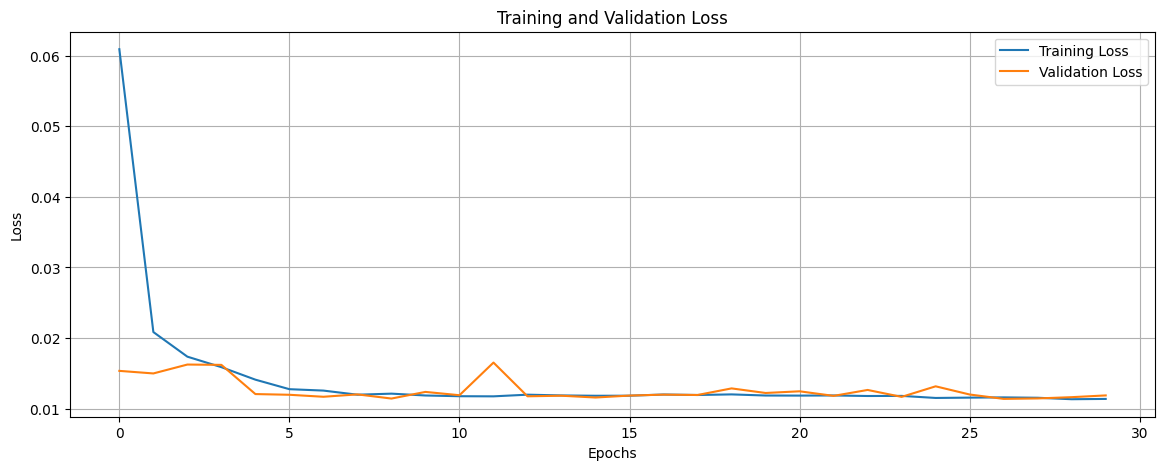

In [ ]:
# Inverse transform the predictions
predicted_rnn_capacity = target_scaler.inverse_transform(rnn_predictions)
actual_rnn_capacity = target_scaler.inverse_transform(y_test.reshape(-1, 1)).flatten()

# Plot training history
plt.figure(figsize=(14, 5))
plt.plot(rnn_history.history['loss'], label='Training Loss')
plt.plot(rnn_history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

The lines of the training and validation loss are very close to each other, meaning it is not overfitted.

Next, we will look at the predicted versus actual values.

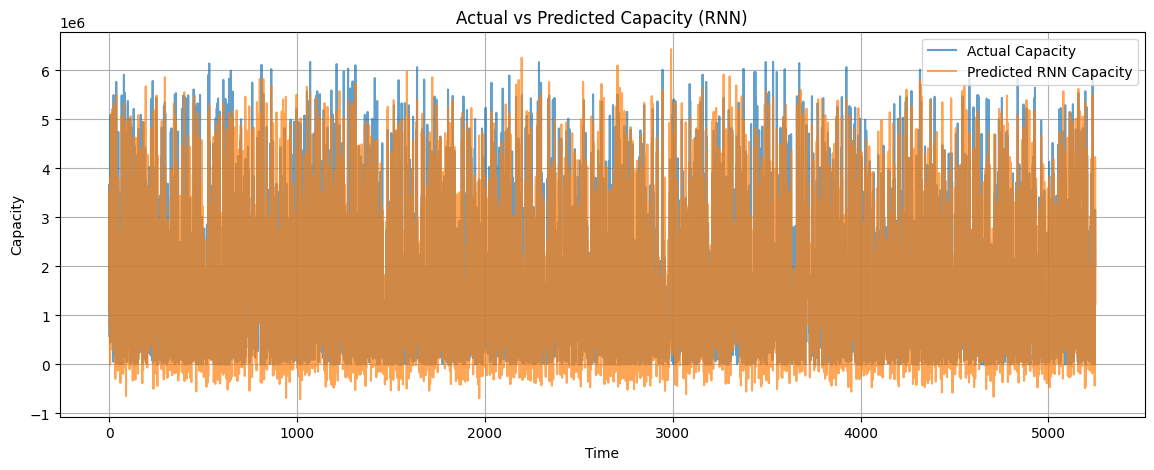

In [ ]:
# Plot Predictions vs Actual Values for RNN
plt.figure(figsize=(14, 5))
plt.plot(actual_capacity, label='Actual Capacity', alpha=0.7)
plt.plot(predicted_rnn_capacity, label='Predicted RNN Capacity', alpha=0.7)
plt.title('Actual vs Predicted Capacity (RNN)')
plt.xlabel('Time')
plt.ylabel('Capacity')
plt.legend()
plt.grid(True)
plt.show()

The actual versus predicted values seem to be predicting better. It still shows that the predicted values are lower than the actual values, but they are closer to each other.

##### Comparisons

GRU_model = Sequential([
    GRU(128, return_sequences=True, input_shape=(seq_length, len(features))),
    Dropout(0.2),
    GRU(64),
    Dropout(0.2),
    Dense(1)
])

# Compile the model
GRU_model.compile(optimizer='adam', loss='mse', metrics=['mae'])

# Print the summary of the RNN model
GRU_model.summary()

In [139]:
# Train the RNN model
GRU_history = GRU_model.fit(
    X_train, y_train,
    epochs=30,
    batch_size=32,
    validation_split=0.2,
    verbose=0
)


In [140]:
# Make predictions using the RNN model
GRU_predictions = GRU_model.predict(X_test)

# Inverse transform the predictions
predicted_GRU_capacity = target_scaler.inverse_transform(GRU_predictions)

165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


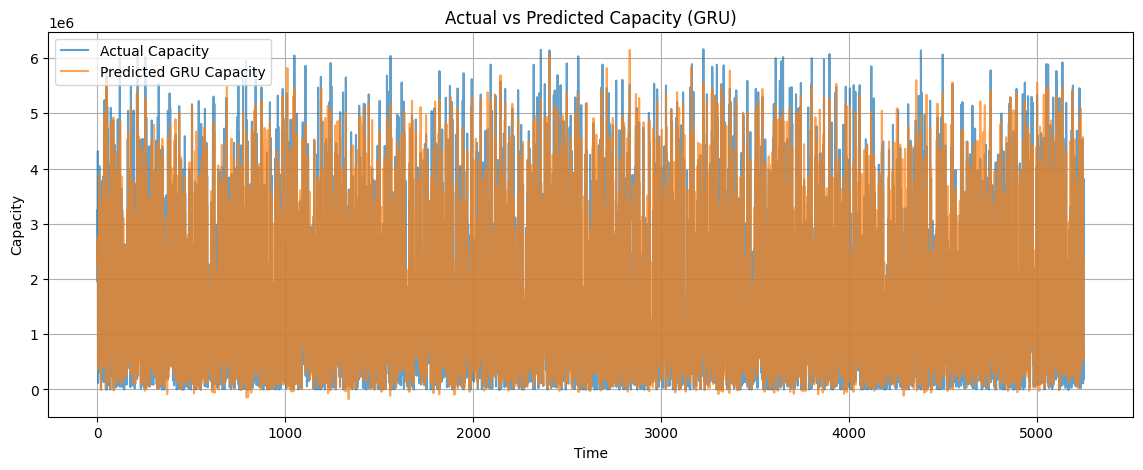

In [141]:
# Plot Predictions vs Actual Values for GRU
plt.figure(figsize=(14, 5))
plt.plot(actual_capacity, label='Actual Capacity', alpha=0.7)
plt.plot(predicted_GRU_capacity, label='Predicted GRU Capacity', alpha=0.7)
plt.title('Actual vs Predicted Capacity (GRU)')
plt.xlabel('Time')
plt.ylabel('Capacity')
plt.legend()
plt.grid(True)
plt.show()

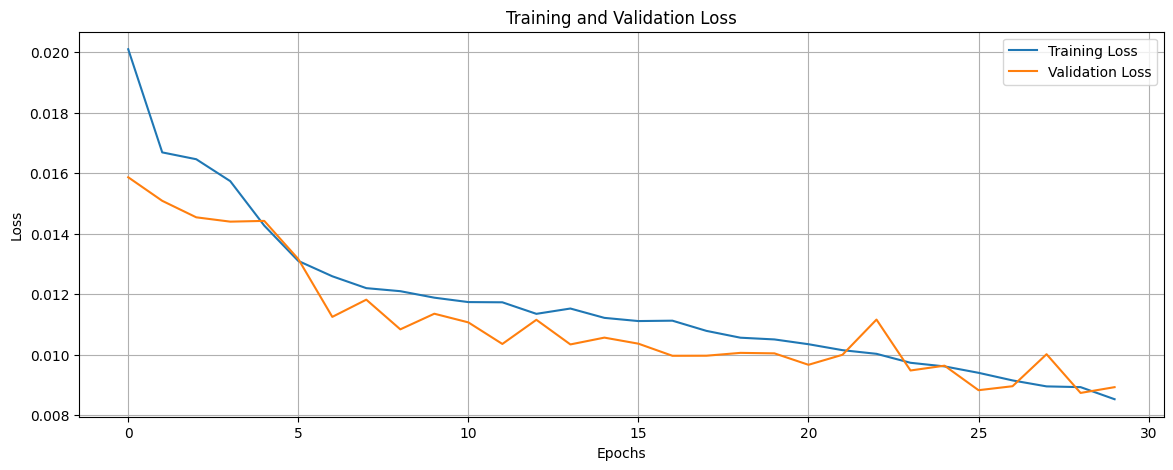

In [142]:
# Plot training history
plt.figure(figsize=(14, 5))
plt.plot(GRU_history.history['loss'], label='Training Loss')
plt.plot(GRU_history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

LSTM Model RMSE: 607392.8809
RNN Model RMSE: 680682.3658
GRU Model RMSE: 585484.4196


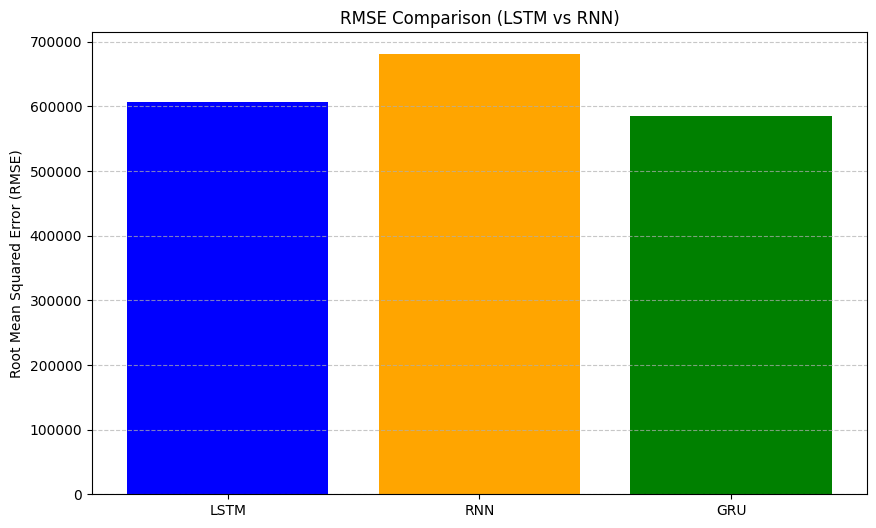

In [143]:
# GRU RMSE
GRU_rmse = np.sqrt(mean_squared_error(actual_capacity, predicted_GRU_capacity))
print(f'GRU Model RMSE: {GRU_rmse:.4f}')

# Create a bar plot
models = ['LSTM', 'RNN', 'GRU']
rmse_values = [lstm_rmse, rnn_rmse, GRU_rmse]

plt.figure(figsize=(10, 6))
plt.bar(models, rmse_values, color=['blue', 'orange', 'green'])
plt.title('RMSE Comparison (LSTM vs RNN)')
plt.ylabel('Root Mean Squared Error (RMSE)')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

In [144]:
from sklearn.metrics import mean_absolute_error, r2_score

# MAE for LSTM and RNN
lstm_mae = mean_absolute_error(actual_capacity, predicted_capacity)
rnn_mae = mean_absolute_error(actual_capacity, predicted_rnn_capacity)
GRU_mae = mean_absolute_error(actual_capacity, predicted_GRU_capacity)

# R² Score for LSTM and RNN
lstm_r2 = r2_score(actual_capacity, predicted_capacity)
rnn_r2 = r2_score(actual_capacity, predicted_rnn_capacity)
GRU_r2 = r2_score(actual_capacity, predicted_GRU_capacity)

# Print additional metrics
print(f'LSTM Model MAE: {lstm_mae:.4f}')
print(f'RNN Model MAE: {rnn_mae:.4f}')
print(f'GRU Model MAE: {GRU_mae:.4f}')
print(f'LSTM Model R² Score: {lstm_r2:.4f}')
print(f'RNN Model R² Score: {rnn_r2:.4f}')
print(f'GRU Model R² Score: {GRU_r2:.4f}')


LSTM Model MAE: 443155.6370
RNN Model MAE: 499941.2034
GRU Model MAE: 433770.5463
LSTM Model R² Score: 0.8458
RNN Model R² Score: 0.8063
GRU Model R² Score: 0.8567


# building further on the rnn

In [145]:
from tensorflow.keras.layers import SimpleRNN, Dropout

rnn2_model = Sequential([
    SimpleRNN(128, return_sequences=True, input_shape=(seq_length, len(features))),
    Dropout(0.3),
    SimpleRNN(64, return_sequences=True),
    Dropout(0.3),
    SimpleRNN(32),
    Dropout(0.3),
    Dense(1)
])

# Compile the model
rnn2_model.compile(optimizer='adam', loss='mse', metrics=['mae'])

# Print the summary of the RNN model
rnn2_model.summary()


c:\Users\Marjolein\Documents\GitHub\EnergieOpwek\tf_env\lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_102"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ simple_rnn_290 (SimpleRNN)      │ (None, 24, 128)        │        17,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_215 (Dropout)           │ (None, 24, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn_291 (SimpleRNN)      │ (None, 24, 64)         │        12,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_216 (Dropout)           │ (None, 24, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn_292 (SimpleRNN)      │ (None, 32)             │         3,104 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_217 (Dropout)           │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_107 (Dense)               │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 32,513 (127.00 KB)

 Trainable params: 32,513 (127.00 KB)

 Non-trainable params: 0 (0.00 B)

In [146]:
# Train the RNN model
rnn2_history = rnn2_model.fit(
    X_train, y_train,
    epochs=30,
    batch_size=32,
    validation_split=0.2,
    verbose=0
)

In [147]:
# Make predictions using the RNN model
rnn2_predictions = rnn2_model.predict(X_test)

# Inverse transform the predictions
predicted_rnn2_capacity = target_scaler.inverse_transform(rnn2_predictions)

165/165 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


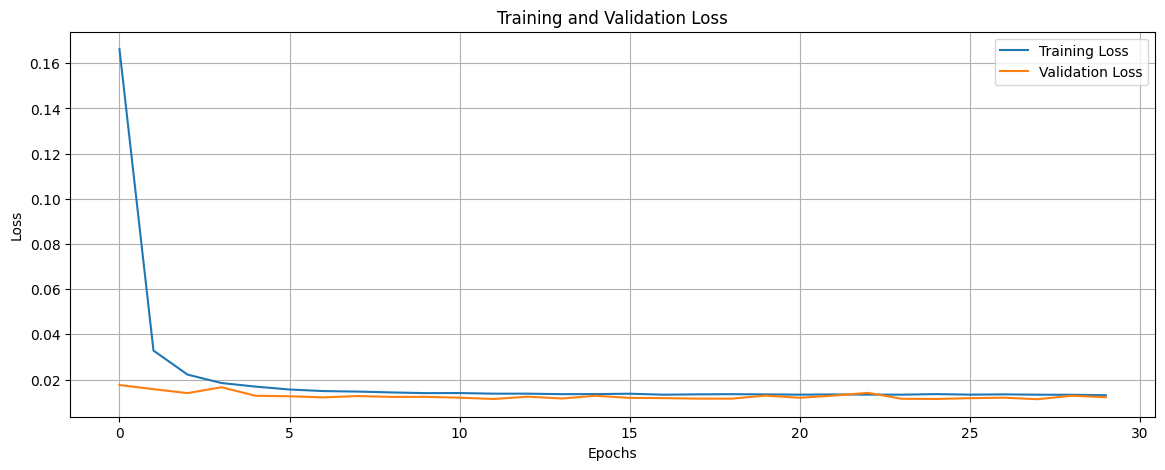

In [148]:
# Plot training history
plt.figure(figsize=(14, 5))
plt.plot(rnn2_history.history['loss'], label='Training Loss')
plt.plot(rnn2_history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

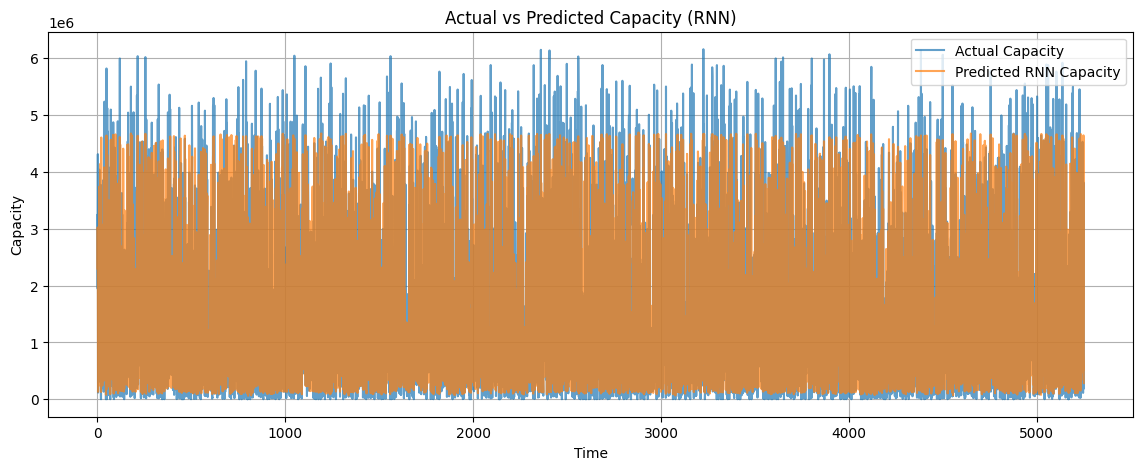

In [149]:
# Plot Predictions vs Actual Values for RNN
plt.figure(figsize=(14, 5))
plt.plot(actual_capacity, label='Actual Capacity', alpha=0.7)
plt.plot(predicted_rnn2_capacity, label='Predicted RNN Capacity', alpha=0.7)
plt.title('Actual vs Predicted Capacity (RNN)')
plt.xlabel('Time')
plt.ylabel('Capacity')
plt.legend()
plt.grid(True)
plt.show()


In [150]:
rnn2_rmse = np.sqrt(mean_squared_error(actual_capacity, predicted_rnn2_capacity))
r2_score_rnn2 = r2_score(actual_capacity, predicted_rnn2_capacity)
print(f'RNN2 Model RMSE: {rnn2_rmse:.4f}')
print(f'RNN2 Model R² Score: {r2_score_rnn2:.4f}')

RNN2 Model RMSE: 690709.7698
RNN2 Model R² Score: 0.8006


#### L2 

In [151]:
from tensorflow.keras.regularizers import l2

rnn3_model = Sequential([
    SimpleRNN(128, return_sequences=True, kernel_regularizer=l2(0.01), input_shape=(seq_length, len(features))),
    Dropout(0.3),
    SimpleRNN(64, kernel_regularizer=l2(0.01)),
    Dropout(0.3),
    Dense(1)
])


c:\Users\Marjolein\Documents\GitHub\EnergieOpwek\tf_env\lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [152]:
# Compile the model
rnn3_model.compile(optimizer='adam', loss='mse', metrics=['mae'])

# Print the summary of the RNN model
rnn3_model.summary()

Model: "sequential_103"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ simple_rnn_293 (SimpleRNN)      │ (None, 24, 128)        │        17,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_218 (Dropout)           │ (None, 24, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn_294 (SimpleRNN)      │ (None, 64)             │        12,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_219 (Dropout)           │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_108 (Dense)               │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 29,441 (115.00 KB)

 Trainable params: 29,441 (115.00 KB)

 Non-trainable params: 0 (0.00 B)

In [153]:
# Train the RNN model
rnn3_history = rnn3_model.fit(
    X_train, y_train,
    epochs=30,
    batch_size=32,
    validation_split=0.2,
    verbose=0
)

In [154]:
# Make predictions using the RNN model
rnn3_predictions = rnn3_model.predict(X_test)

# Inverse transform the predictions
predicted_rnn3_capacity = target_scaler.inverse_transform(rnn3_predictions)

165/165 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


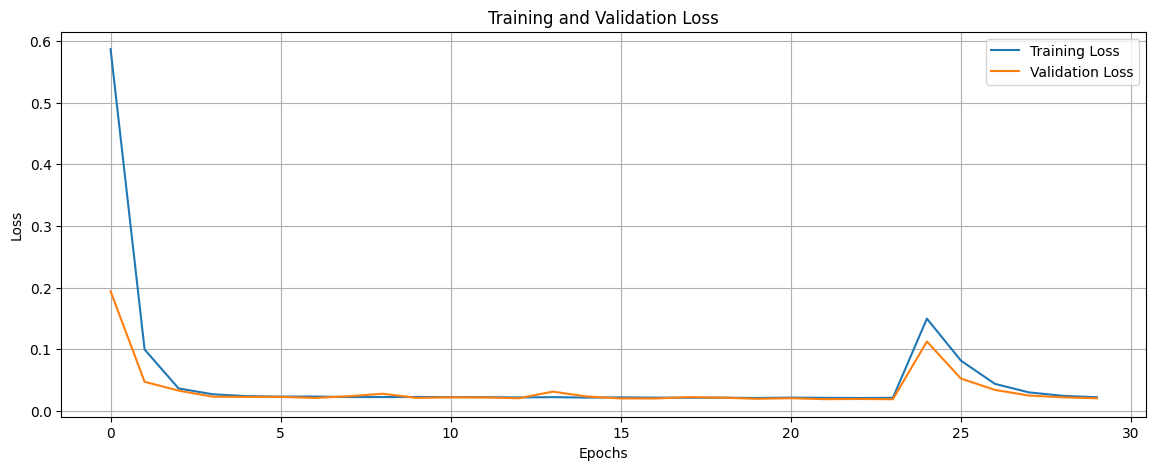

In [155]:
# Plot training history
plt.figure(figsize=(14, 5))
plt.plot(rnn3_history.history['loss'], label='Training Loss')
plt.plot(rnn3_history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

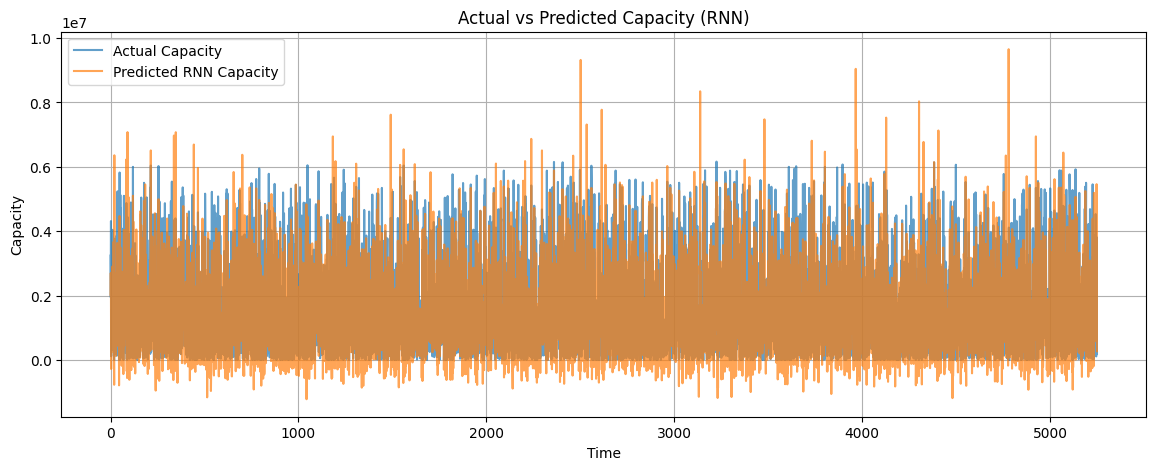

In [156]:
# Plot Predictions vs Actual Values for RNN
plt.figure(figsize=(14, 5))
plt.plot(actual_capacity, label='Actual Capacity', alpha=0.7)
plt.plot(predicted_rnn3_capacity, label='Predicted RNN Capacity', alpha=0.7)
plt.title('Actual vs Predicted Capacity (RNN)')
plt.xlabel('Time')
plt.ylabel('Capacity')
plt.legend()
plt.grid(True)
plt.show()

In [157]:
rnn3_rmse = np.sqrt(mean_squared_error(actual_capacity, predicted_rnn3_capacity))
r2_score_rnn3 = r2_score(actual_capacity, predicted_rnn3_capacity)

print(f'RNN Model RMSE: {rnn_rmse:.4f}')
print(f'RNN Model R² Score: {rnn_r2:.4f}')
print(f'RNN2 Model RMSE: {rnn2_rmse:.4f}')
print(f'RNN2 Model R² Score: {r2_score_rnn2:.4f}')
print(f'RNN3 Model RMSE: {rnn3_rmse:.4f}')
print(f'RNN3 Model R² Score: {r2_score_rnn3:.4f}')


RNN Model RMSE: 680682.3658
RNN Model R² Score: 0.8063
RNN2 Model RMSE: 690709.7698
RNN2 Model R² Score: 0.8006
RNN3 Model RMSE: 809160.1414
RNN3 Model R² Score: 0.7263


### reduce complexity 

In [158]:
rnn4_model = Sequential([
    SimpleRNN(64, return_sequences=True, input_shape=(seq_length, len(features))),
    Dropout(0.2),
    SimpleRNN(32),
    Dropout(0.2),
    Dense(1)
])

# Compile the model
rnn4_model.compile(optimizer='adam', loss='mse', metrics=['mae'])

# Print the summary of the RNN model
rnn4_model.summary()

c:\Users\Marjolein\Documents\GitHub\EnergieOpwek\tf_env\lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_104"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ simple_rnn_295 (SimpleRNN)      │ (None, 24, 64)         │         4,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_220 (Dropout)           │ (None, 24, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn_296 (SimpleRNN)      │ (None, 32)             │         3,104 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_221 (Dropout)           │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_109 (Dense)               │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,553 (29.50 KB)

 Trainable params: 7,553 (29.50 KB)

 Non-trainable params: 0 (0.00 B)

In [159]:
# Train the RNN model
rnn4_history = rnn2_model.fit(
    X_train, y_train,
    epochs=30,
    batch_size=32,
    validation_split=0.2,
    verbose=0
)

In [160]:
# Make predictions using the RNN model
rnn4_predictions = rnn4_model.predict(X_test)

# Inverse transform the predictions
predicted_rnn4_capacity = target_scaler.inverse_transform(rnn4_predictions)

165/165 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


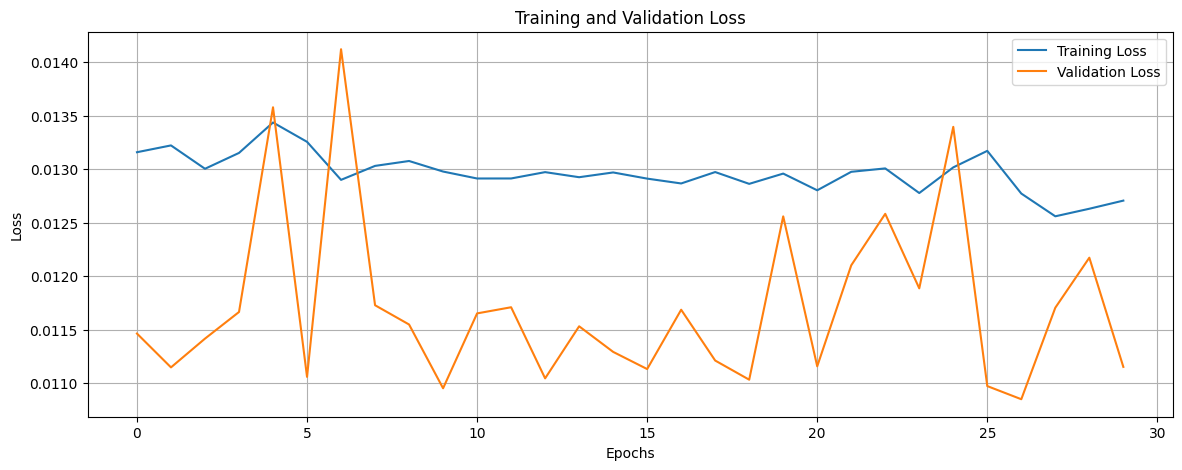

In [161]:
# Plot training history
plt.figure(figsize=(14, 5))
plt.plot(rnn4_history.history['loss'], label='Training Loss')
plt.plot(rnn4_history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

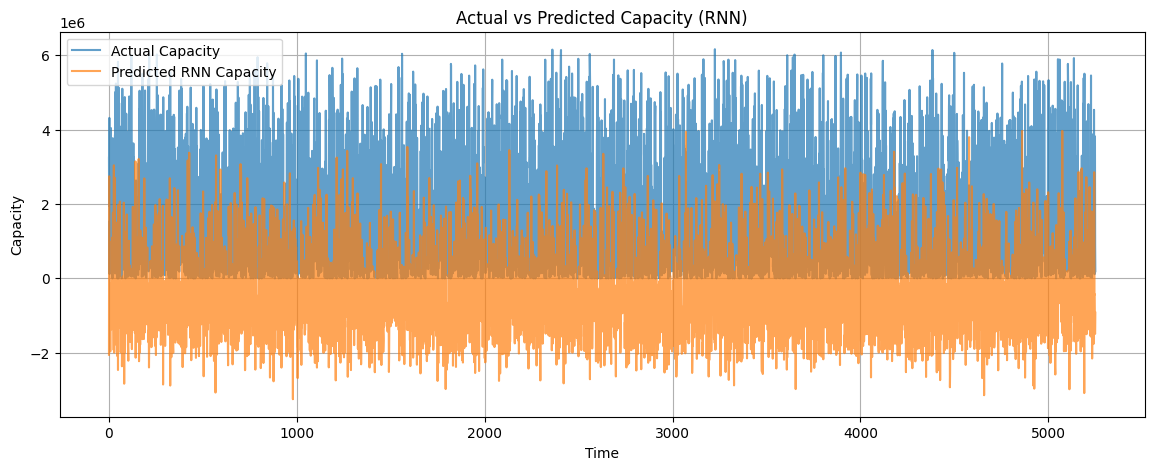

In [162]:
# Plot Predictions vs Actual Values for RNN
plt.figure(figsize=(14, 5))
plt.plot(actual_capacity, label='Actual Capacity', alpha=0.7)
plt.plot(predicted_rnn4_capacity, label='Predicted RNN Capacity', alpha=0.7)
plt.title('Actual vs Predicted Capacity (RNN)')
plt.xlabel('Time')
plt.ylabel('Capacity')
plt.legend()
plt.grid(True)
plt.show()

In [163]:
rnn4_rmse = np.sqrt(mean_squared_error(actual_capacity, predicted_rnn4_capacity))
r2_score_rnn4 = r2_score(actual_capacity, predicted_rnn4_capacity)

print(f'RNN Model RMSE: {rnn_rmse:.4f}')
print(f'RNN Model R² Score: {rnn_r2:.4f}')
print(f'RNN2 Model RMSE: {rnn2_rmse:.4f}')
print(f'RNN2 Model R² Score: {r2_score_rnn2:.4f}')
print(f'RNN3 Model RMSE: {rnn3_rmse:.4f}')
print(f'RNN3 Model R² Score: {r2_score_rnn3:.4f}')
print(f'RNN4 Model RMSE: {rnn4_rmse:.4f}')
print(f'RNN4 Model R² Score: {r2_score_rnn4:.4f}')

RNN Model RMSE: 680682.3658
RNN Model R² Score: 0.8063
RNN2 Model RMSE: 690709.7698
RNN2 Model R² Score: 0.8006
RNN3 Model RMSE: 809160.1414
RNN3 Model R² Score: 0.7263
RNN4 Model RMSE: 2911505.6873
RNN4 Model R² Score: -2.5434


### early stopping on the 3rd model 

In [164]:
from tensorflow.keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

rnn3_history = rnn3_model.fit(
    X_train, y_train,
    epochs=100,
    batch_size=50,
    validation_split=0.2,
    callbacks=[early_stopping],
    verbose=0
)

In [165]:
# Make predictions using the RNN model
rnn3_predictions = rnn3_model.predict(X_test)

# Inverse transform the predictions
predicted_rnn3_capacity = target_scaler.inverse_transform(rnn3_predictions)

165/165 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


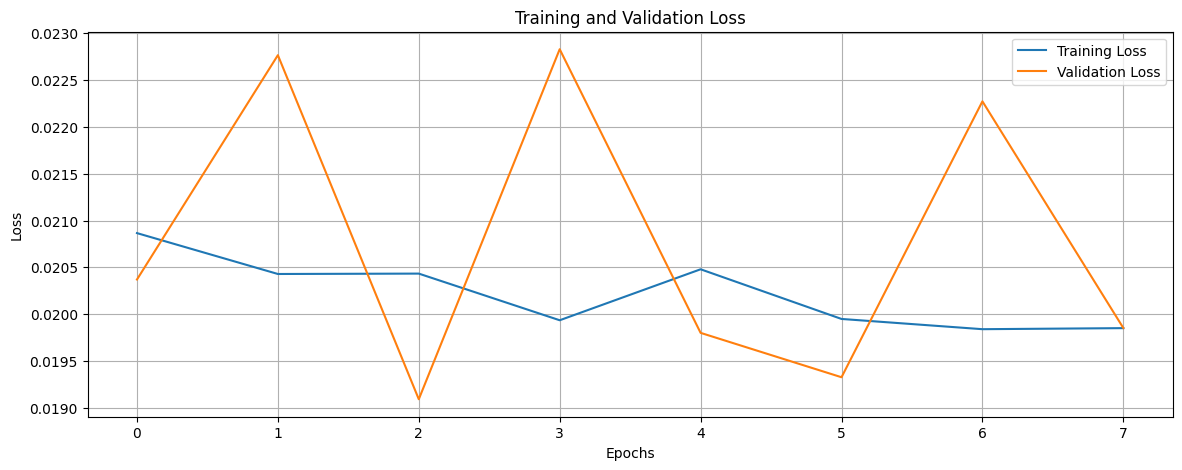

In [166]:
# Plot training history
plt.figure(figsize=(14, 5))
plt.plot(rnn3_history.history['loss'], label='Training Loss')
plt.plot(rnn3_history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

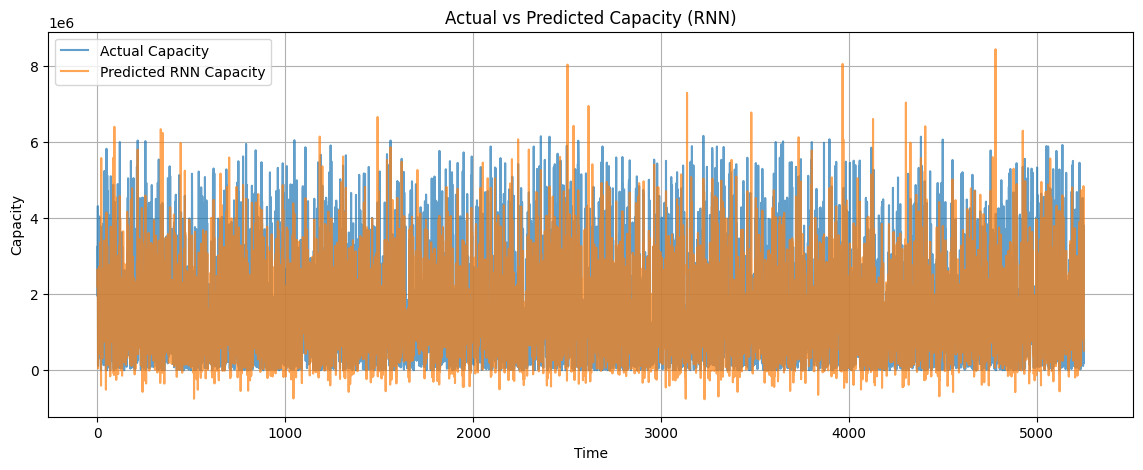

In [167]:
# Plot Predictions vs Actual Values for RNN
plt.figure(figsize=(14, 5))
plt.plot(actual_capacity, label='Actual Capacity', alpha=0.7)
plt.plot(predicted_rnn3_capacity, label='Predicted RNN Capacity', alpha=0.7)
plt.title('Actual vs Predicted Capacity (RNN)')
plt.xlabel('Time')
plt.ylabel('Capacity')
plt.legend()
plt.grid(True)
plt.show()

In [168]:
rnn5_rmse = np.sqrt(mean_squared_error(actual_capacity, predicted_rnn3_capacity))
r2_score_rnn5 = r2_score(actual_capacity, predicted_rnn3_capacity)

print(f'RNN Model RMSE: {rnn_rmse:.4f}')
print(f'RNN Model R² Score: {rnn_r2:.4f}')
print(f'RNN2 Model RMSE: {rnn2_rmse:.4f}')
print(f'RNN2 Model R² Score: {r2_score_rnn2:.4f}')
print(f'RNN3 Model RMSE: {rnn3_rmse:.4f}')
print(f'RNN3 Model R² Score: {r2_score_rnn3:.4f}')
print(f'RNN4 Model RMSE: {rnn4_rmse:.4f}')
print(f'RNN5 Model R² Score: {r2_score_rnn5:.4f}')
print(f'RNN5 Model RMSE: {rnn5_rmse:.4f}')

RNN Model RMSE: 680682.3658
RNN Model R² Score: 0.8063
RNN2 Model RMSE: 690709.7698
RNN2 Model R² Score: 0.8006
RNN3 Model RMSE: 809160.1414
RNN3 Model R² Score: 0.7263
RNN4 Model RMSE: 2911505.6873
RNN5 Model R² Score: 0.7335
RNN5 Model RMSE: 798542.4332


In [169]:
import numpy as np
from sklearn.model_selection import KFold
from sklearn.metrics import r2_score
from sklearn.preprocessing import StandardScaler

# TensorFlow imports
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.optimizers import Adam

# K-Fold Cross Validation
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Function to define the RNN model
def create_rnn_model():
    model = Sequential()
    model.add(SimpleRNN(64, return_sequences=False, input_shape=(X.shape[1], X.shape[2])))
    model.add(Dense(1))  # Output layer for regression
    model.compile(optimizer=Adam(), loss='mse', metrics=['mae'])
    return model

# K-Fold Cross Validation Loop
fold_no = 1
for train_index, val_index in kf.split(X):
    print(f"Training fold {fold_no}...")

    # Split data
    X_train, X_val = X[train_index], X[val_index]
    y_train, y_val = y[train_index], y[val_index]

    # Create a new model for each fold
    model = create_rnn_model()

    # Train the model
    model.fit(X_train, y_train, epochs=15, batch_size=64, verbose=0)

    # Predict and calculate R²
    y_pred = model.predict(X_val).flatten()
    r2 = r2_score(y_val, y_pred)
    
    print(f"Fold {fold_no} - R²: {r2:.4f}")
    fold_no += 1


Training fold 1...


c:\Users\Marjolein\Documents\GitHub\EnergieOpwek\tf_env\lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


165/165 ━━━━━━━━━━━━━━━━━━━━ 0s 894us/step
Fold 1 - R²: 0.8151
Training fold 2...


c:\Users\Marjolein\Documents\GitHub\EnergieOpwek\tf_env\lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


165/165 ━━━━━━━━━━━━━━━━━━━━ 0s 914us/step
Fold 2 - R²: 0.8194
Training fold 3...


c:\Users\Marjolein\Documents\GitHub\EnergieOpwek\tf_env\lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


165/165 ━━━━━━━━━━━━━━━━━━━━ 0s 814us/step
Fold 3 - R²: 0.8091
Training fold 4...


c:\Users\Marjolein\Documents\GitHub\EnergieOpwek\tf_env\lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


165/165 ━━━━━━━━━━━━━━━━━━━━ 0s 914us/step
Fold 4 - R²: 0.8316
Training fold 5...


c:\Users\Marjolein\Documents\GitHub\EnergieOpwek\tf_env\lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


165/165 ━━━━━━━━━━━━━━━━━━━━ 0s 912us/step
Fold 5 - R²: 0.7904


In [170]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, Dense, Input
from tensorflow.keras.optimizers import Adam

# Function to define the RNN model
def create_rnn_model():
    model = Sequential([
        Input(shape=(X.shape[1], X.shape[2])),
        SimpleRNN(64, return_sequences=False),
        Dense(1)  # Output layer for regression
    ])
    model.compile(optimizer=Adam(), loss='mse', metrics=['mae'])
    return model


In [171]:
fold_no = 1
for train_index, val_index in kf.split(X):
    # Split data
    X_train, X_val = X[train_index], X[val_index]
    y_train, y_val = y[train_index], y[val_index]

    # Create a new model for each fold
    model = create_rnn_model()

    # Train the model
    model.fit(X_train, y_train, epochs=30, batch_size=64, verbose=0)

    # Predict and calculate R²
    y_pred = model.predict(X_val).flatten()
    r2 = r2_score(y_val, y_pred)
    
    # Print results for each fold
    print(f"Fold {fold_no} - R²: {r2:.4f}")
    fold_no += 1


165/165 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Fold 1 - R²: 0.8198
165/165 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Fold 2 - R²: 0.8321
165/165 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Fold 3 - R²: 0.8342
165/165 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Fold 4 - R²: 0.8407
165/165 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Fold 5 - R²: 0.8215


In [172]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, Dense, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

# Function to define the RNN model
def create_rnn_model():
    model = Sequential([
        Input(shape=(X.shape[1], X.shape[2])),
        SimpleRNN(64, return_sequences=True),  # First RNN layer
        SimpleRNN(32, return_sequences=False),  # Second RNN layer
        Dense(32, activation='relu'),  # Hidden dense layer
        Dense(1)  # Output layer for regression
    ])
    model.compile(optimizer=Adam(), loss='mse', metrics=['mae'])
    return model

# Early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# K-Fold Cross Validation Loop
fold_no = 1
for train_index, val_index in kf.split(X):
    # Split data
    X_train, X_val = X[train_index], X[val_index]
    y_train, y_val = y[train_index], y[val_index]

    # Create a new model for each fold
    model = create_rnn_model()

    # Train the model with early stopping
    model.fit(
        X_train, y_train,
        validation_data=(X_val, y_val),
        epochs=100, batch_size=64, verbose=0,
        callbacks=[early_stopping]
    )

    # Predict and calculate R²
    y_pred = model.predict(X_val).flatten()
    r2 = r2_score(y_val, y_pred)
    
    # Print results for each fold
    print(f"Fold {fold_no} - R²: {r2:.4f}")
    fold_no += 1


165/165 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Fold 1 - R²: 0.8269
165/165 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Fold 2 - R²: 0.8309
165/165 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Fold 3 - R²: 0.8248
165/165 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Fold 4 - R²: 0.8336
165/165 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Fold 5 - R²: 0.8218


In [173]:
# import numpy as np
# from sklearn.model_selection import KFold
# from sklearn.metrics import r2_score
# from sklearn.preprocessing import StandardScaler
# from tensorflow.keras.models import Sequential
# from tensorflow.keras.layers import SimpleRNN, Dense, Dropout
# from tensorflow.keras.optimizers import Adam

# # Standardize features
# scaler = StandardScaler()
# X = scaler.fit_transform(X.reshape(-1, X.shape[-1])).reshape(X.shape)

# # Function to create RNN model
# def create_rnn_model(units=64, layers=1, dropout_rate=0.2, learning_rate=0.001):
#     model = Sequential()
#     model.add(SimpleRNN(units, return_sequences=layers > 1, input_shape=(X.shape[1], X.shape[2])))
    
#     for _ in range(layers - 1):
#         model.add(SimpleRNN(units, return_sequences=False))
#         model.add(Dropout(dropout_rate))
    
#     model.add(Dense(1))
#     model.compile(optimizer=Adam(learning_rate=learning_rate), loss='mse')
#     return model

# # List of hyperparameters to search
# param_grid = {
#     'units': [32, 64, 128],
#     'layers': [1, 2, 3],
#     'dropout_rate': [0.2, 0.3, 0.4],
#     'batch_size': [32, 64],
#     'epochs': [50, 100],
#     'learning_rate': [0.001, 0.0005],
# }

# # Initialize K-Fold
# kf = KFold(n_splits=5, shuffle=True, random_state=42)

# # Manual grid search loop
# best_score = -np.inf
# best_params = None

# for units in param_grid['units']:
#     for layers in param_grid['layers']:
#         for dropout_rate in param_grid['dropout_rate']:
#             for batch_size in param_grid['batch_size']:
#                 for epochs in param_grid['epochs']:
#                     for learning_rate in param_grid['learning_rate']:
#                         print(f"Training with units={units}, layers={layers}, dropout_rate={dropout_rate}, "
#                               f"batch_size={batch_size}, epochs={epochs}, learning_rate={learning_rate}")
                        
#                         # Initialize model
#                         model = create_rnn_model(units, layers, dropout_rate, learning_rate)
                        
#                         fold_scores = []
#                         for train_index, val_index in kf.split(X):
#                             # Split data
#                             X_train, X_val = X[train_index], X[val_index]
#                             y_train, y_val = y[train_index], y[val_index]
                            
#                             # Train model
#                             model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, verbose=0)
                            
#                             # Predict and evaluate
#                             y_pred = model.predict(X_val).squeeze()
#                             fold_r2 = r2_score(y_val, y_pred)
#                             fold_scores.append(fold_r2)
                        
#                         mean_score = np.mean(fold_scores)
#                         print(f"Mean R² for this configuration: {mean_score:.4f}")
                        
#                         # Check if this is the best model
#                         if mean_score > best_score:
#                             best_score = mean_score
#                             best_params = {
#                                 'units': units,
#                                 'layers': layers,
#                                 'dropout_rate': dropout_rate,
#                                 'batch_size': batch_size,
#                                 'epochs': epochs,
#                                 'learning_rate': learning_rate,
#                             }

# print("\nBest R² Score: {:.4f}".format(best_score))
# print("Best Hyperparameters:", best_params)


In [174]:
# import numpy as np
# from sklearn.model_selection import KFold
# from sklearn.metrics import r2_score
# from sklearn.preprocessing import StandardScaler
# from tensorflow.keras.models import Sequential
# from tensorflow.keras.layers import SimpleRNN, Dense, Dropout
# from tensorflow.keras.optimizers import Adam
# from tensorflow.keras.callbacks import EarlyStopping

# # Function to create RNN model with parameters
# def create_rnn_model(units=64, layers=1, dropout_rate=0.2, learning_rate=0.001):
#     model = Sequential()
#     # First RNN layer
#     model.add(SimpleRNN(units, return_sequences=(layers > 1), input_shape=(X.shape[1], X.shape[2])))
    
#     # Additional RNN layers with Dropout
#     for i in range(1, layers):
#         model.add(SimpleRNN(units, return_sequences=(i < layers - 1)))
#         model.add(Dropout(dropout_rate))
    
#     # Output layer
#     model.add(Dense(1))
    
#     # Compile the model
#     model.compile(optimizer=Adam(learning_rate=learning_rate), loss='mse')
#     return model

# # List of hyperparameters to search
# param_grid = {
#     'units': [64, 128, 256],
#     'layers': [3, 4, 5],
#     'dropout_rate': [0.2, 0.3, 0.4],
#     'batch_size': [64, 128],
#     'learning_rate': [0.1, 0.2],
# }

# # Initialize K-Fold cross-validation
# kf = KFold(n_splits=5, shuffle=True, random_state=42)

# # Manual grid search loop
# best_score = -np.inf
# best_params = None

# for units in param_grid['units']:
#     for layers in param_grid['layers']:
#         for dropout_rate in param_grid['dropout_rate']:
#             for batch_size in param_grid['batch_size']:
#                 for learning_rate in param_grid['learning_rate']:
#                         print(f"Training with units={units}, layers={layers}, dropout_rate={dropout_rate}, "
#                               f"batch_size={batch_size},learning_rate={learning_rate}")
                        
#                         # Initialize model
#                         model = create_rnn_model(units, layers, dropout_rate, learning_rate)

#                         # Early stopping callback
#                         early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

#                         fold_scores = []
#                         for train_index, val_index in kf.split(X):
#                             # Split data
#                             X_train, X_val = X[train_index], X[val_index]
#                             y_train, y_val = y[train_index], y[val_index]
                            
#                             # Train model with early stopping
#                             model.fit(X_train, y_train, epochs=30, batch_size=batch_size, 
#                                       validation_data=(X_val, y_val), verbose=0, callbacks=[early_stopping])
                            
#                             # Predict and evaluate
#                             y_pred = model.predict(X_val).squeeze()
#                             fold_r2 = r2_score(y_val, y_pred)
#                             fold_scores.append(fold_r2)
                        
#                         mean_score = np.mean(fold_scores)
#                         print(f"Mean R² for this configuration: {mean_score:.4f}")
                        
#                         # Check if this is the best model
#                         if mean_score > best_score:
#                             best_score = mean_score
#                             best_params = {
#                                 'units': units,
#                                 'layers': layers,
#                                 'dropout_rate': dropout_rate,
#                                 'batch_size': batch_size,
#                                 'learning_rate': learning_rate,
#                             }

# # Print the best results
# print("\nBest R² Score: {:.4f}".format(best_score))
# print("Best Hyperparameters:", best_params)


In [175]:
import numpy as np
from sklearn.model_selection import KFold
from sklearn.metrics import r2_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
import optuna

# Function to create RNN model with parameters
def create_rnn_model(units=64, layers=1, dropout_rate=0.2, learning_rate=0.001):
    model = Sequential()
    # First RNN layer
    model.add(SimpleRNN(units, return_sequences=(layers > 1), input_shape=(X_train.shape[1], X_train.shape[2])))

    # Additional RNN layers with Dropout
    for i in range(1, layers):
        model.add(SimpleRNN(units, return_sequences=(i < layers - 1)))
        model.add(Dropout(dropout_rate))

    # Output layer
    model.add(Dense(1))

    # Compile the model
    model.compile(optimizer=Adam(learning_rate=learning_rate), loss='mse')
    return model

# Initialize K-Fold cross-validation on the training set
kf = KFold(n_splits=3, shuffle=True, random_state=42)

# Define the objective function for Optuna optimization
def objective(trial):
    # Suggest hyperparameters to optimize
    units = trial.suggest_categorical('units', [64, 128, 256])
    layers = trial.suggest_int('layers', 1, 5)
    dropout_rate = trial.suggest_float('dropout_rate', 0.1, 0.4)
    learning_rate = trial.suggest_float('learning_rate', 1e-4, 1e-2, log=True)
    batch_size = trial.suggest_categorical('batch_size', [32, 64, 128])

    # Create the model with the suggested hyperparameters
    model = create_rnn_model(units, layers, dropout_rate, learning_rate)

    # Early stopping callback
    early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

    fold_scores = []
    for train_index, val_index in kf.split(np.arange(len(X_train))):
        # Split data
        X_fold_train, X_fold_val = X_train[train_index], X_train[val_index]
        y_fold_train, y_fold_val = y_train[train_index], y_train[val_index]

        # Train model with early stopping
        model.fit(X_fold_train, y_fold_train, epochs=30, batch_size=batch_size,
                  validation_data=(X_fold_val, y_fold_val), verbose=0, callbacks=[early_stopping])

        # Predict and evaluate on validation fold
        y_pred = model.predict(X_fold_val).squeeze()
        fold_r2 = r2_score(y_fold_val, y_pred)
        fold_scores.append(fold_r2)

    # Return the mean R² score for this trial
    return np.mean(fold_scores)

# Create a study and optimize
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=50)

# Print the best results
print("\nBest Hyperparameters:", study.best_params)


[I 2025-01-16 22:37:47,658] A new study created in memory with name: no-name-867c5dce-73cf-48a4-9b33-842494d5d687
c:\Users\Marjolein\Documents\GitHub\EnergieOpwek\tf_env\lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


[I 2025-01-16 22:40:12,962] Trial 0 finished with value: 0.8080852489313078 and parameters: {'units': 128, 'layers': 4, 'dropout_rate': 0.3005963086516974, 'learning_rate': 0.00028041031793138877, 'batch_size': 128}. Best is trial 0 with value: 0.8080852489313078.
c:\Users\Marjolein\Documents\GitHub\EnergieOpwek\tf_env\lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


[I 2025-01-16 22:43:19,841] Trial 1 finished with value: 0.8270968796996624 and parameters: {'units': 64, 'layers': 5, 'dropout_rate': 0.19914152072871166, 'learning_rate': 0.00027838984869815817, 'batch_size': 32}. Best is trial 1 with value: 0.8270968796996624.
c:\Users\Marjolein\Documents\GitHub\EnergieOpwek\tf_env\lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


[I 2025-01-16 22:44:49,591] Trial 2 finished with value: 0.8141229160221742 and parameters: {'units': 128, 'layers': 3, 'dropout_rate': 0.21700338056070873, 'learning_rate': 0.000892994981866979, 'batch_size': 64}. Best is trial 1 with value: 0.8270968796996624.
c:\Users\Marjolein\Documents\GitHub\EnergieOpwek\tf_env\lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


[I 2025-01-16 22:45:30,741] Trial 3 finished with value: 0.8091199359048953 and parameters: {'units': 64, 'layers': 2, 'dropout_rate': 0.16160739551646627, 'learning_rate': 0.008101504702636672, 'batch_size': 32}. Best is trial 1 with value: 0.8270968796996624.
c:\Users\Marjolein\Documents\GitHub\EnergieOpwek\tf_env\lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


[I 2025-01-16 22:46:12,925] Trial 4 finished with value: 0.7979178613435641 and parameters: {'units': 256, 'layers': 1, 'dropout_rate': 0.3405281762769241, 'learning_rate': 0.003988197877273097, 'batch_size': 64}. Best is trial 1 with value: 0.8270968796996624.
c:\Users\Marjolein\Documents\GitHub\EnergieOpwek\tf_env\lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 917us/step
219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 841us/step


[I 2025-01-16 22:46:34,625] Trial 5 finished with value: 0.8313932887876261 and parameters: {'units': 128, 'layers': 1, 'dropout_rate': 0.305034565264923, 'learning_rate': 0.003077837666041141, 'batch_size': 128}. Best is trial 5 with value: 0.8313932887876261.
c:\Users\Marjolein\Documents\GitHub\EnergieOpwek\tf_env\lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


[I 2025-01-16 22:48:10,691] Trial 6 finished with value: 0.7969298130261836 and parameters: {'units': 64, 'layers': 4, 'dropout_rate': 0.18187645241488642, 'learning_rate': 0.00016175727851095023, 'batch_size': 128}. Best is trial 5 with value: 0.8313932887876261.
c:\Users\Marjolein\Documents\GitHub\EnergieOpwek\tf_env\lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


[I 2025-01-16 22:48:55,290] Trial 7 finished with value: 0.8179001886436591 and parameters: {'units': 64, 'layers': 2, 'dropout_rate': 0.10917693772134202, 'learning_rate': 0.0002695721452983455, 'batch_size': 64}. Best is trial 5 with value: 0.8313932887876261.
c:\Users\Marjolein\Documents\GitHub\EnergieOpwek\tf_env\lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


[I 2025-01-16 22:50:30,925] Trial 8 finished with value: 0.7635808020639208 and parameters: {'units': 256, 'layers': 3, 'dropout_rate': 0.2336376169224468, 'learning_rate': 0.00028007542614258744, 'batch_size': 128}. Best is trial 5 with value: 0.8313932887876261.
c:\Users\Marjolein\Documents\GitHub\EnergieOpwek\tf_env\lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


[I 2025-01-16 22:51:28,308] Trial 9 finished with value: 0.8254283029396077 and parameters: {'units': 256, 'layers': 1, 'dropout_rate': 0.1406177092201626, 'learning_rate': 0.0008577277859433787, 'batch_size': 64}. Best is trial 5 with value: 0.8313932887876261.
c:\Users\Marjolein\Documents\GitHub\EnergieOpwek\tf_env\lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


[I 2025-01-16 22:52:16,258] Trial 10 finished with value: 0.8207968570855835 and parameters: {'units': 128, 'layers': 2, 'dropout_rate': 0.37513641372677486, 'learning_rate': 0.002307590657212464, 'batch_size': 128}. Best is trial 5 with value: 0.8313932887876261.
c:\Users\Marjolein\Documents\GitHub\EnergieOpwek\tf_env\lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


[I 2025-01-16 22:54:21,659] Trial 11 finished with value: 0.7989629045257911 and parameters: {'units': 64, 'layers': 5, 'dropout_rate': 0.2975498600037623, 'learning_rate': 0.002299894559135522, 'batch_size': 32}. Best is trial 5 with value: 0.8313932887876261.
c:\Users\Marjolein\Documents\GitHub\EnergieOpwek\tf_env\lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step


[I 2025-01-16 22:57:57,192] Trial 12 finished with value: 0.8245296788777422 and parameters: {'units': 128, 'layers': 5, 'dropout_rate': 0.27686468557310373, 'learning_rate': 0.00010831662796664738, 'batch_size': 32}. Best is trial 5 with value: 0.8313932887876261.
c:\Users\Marjolein\Documents\GitHub\EnergieOpwek\tf_env\lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


[I 2025-01-16 23:00:17,759] Trial 13 finished with value: 0.8290031540104251 and parameters: {'units': 64, 'layers': 4, 'dropout_rate': 0.2157423736221854, 'learning_rate': 0.000499277182642702, 'batch_size': 32}. Best is trial 5 with value: 0.8313932887876261.
c:\Users\Marjolein\Documents\GitHub\EnergieOpwek\tf_env\lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step


[I 2025-01-16 23:03:22,161] Trial 14 finished with value: 0.8151439355698352 and parameters: {'units': 128, 'layers': 4, 'dropout_rate': 0.25824677765166976, 'learning_rate': 0.0005900420091348986, 'batch_size': 128}. Best is trial 5 with value: 0.8313932887876261.
c:\Users\Marjolein\Documents\GitHub\EnergieOpwek\tf_env\lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


[I 2025-01-16 23:05:29,993] Trial 15 finished with value: 0.8087110062654143 and parameters: {'units': 64, 'layers': 3, 'dropout_rate': 0.35057911329298486, 'learning_rate': 0.0014467030023300655, 'batch_size': 32}. Best is trial 5 with value: 0.8313932887876261.
c:\Users\Marjolein\Documents\GitHub\EnergieOpwek\tf_env\lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


[I 2025-01-16 23:05:57,377] Trial 16 finished with value: 0.8108262292107952 and parameters: {'units': 128, 'layers': 1, 'dropout_rate': 0.3130891391781348, 'learning_rate': 0.009174537446072627, 'batch_size': 128}. Best is trial 5 with value: 0.8313932887876261.
c:\Users\Marjolein\Documents\GitHub\EnergieOpwek\tf_env\lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step


[I 2025-01-16 23:08:41,876] Trial 17 finished with value: -0.0014183429465767599 and parameters: {'units': 128, 'layers': 4, 'dropout_rate': 0.397538564157199, 'learning_rate': 0.004566420125255287, 'batch_size': 32}. Best is trial 5 with value: 0.8313932887876261.
c:\Users\Marjolein\Documents\GitHub\EnergieOpwek\tf_env\lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


[I 2025-01-16 23:09:25,193] Trial 18 finished with value: 0.8116084793057493 and parameters: {'units': 64, 'layers': 2, 'dropout_rate': 0.25614293016729284, 'learning_rate': 0.0005200798667736806, 'batch_size': 128}. Best is trial 5 with value: 0.8313932887876261.
c:\Users\Marjolein\Documents\GitHub\EnergieOpwek\tf_env\lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step


[I 2025-01-16 23:15:29,977] Trial 19 finished with value: 0.2649334019149243 and parameters: {'units': 256, 'layers': 4, 'dropout_rate': 0.2258393944331329, 'learning_rate': 0.0015382187385588643, 'batch_size': 32}. Best is trial 5 with value: 0.8313932887876261.
c:\Users\Marjolein\Documents\GitHub\EnergieOpwek\tf_env\lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


[I 2025-01-16 23:17:18,027] Trial 20 finished with value: 0.8202213586645678 and parameters: {'units': 128, 'layers': 3, 'dropout_rate': 0.32900398577123274, 'learning_rate': 0.003710351866563579, 'batch_size': 128}. Best is trial 5 with value: 0.8313932887876261.
c:\Users\Marjolein\Documents\GitHub\EnergieOpwek\tf_env\lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


[I 2025-01-16 23:20:59,794] Trial 21 finished with value: 0.8187563746194724 and parameters: {'units': 64, 'layers': 5, 'dropout_rate': 0.19686376157518135, 'learning_rate': 0.00043045046150593517, 'batch_size': 32}. Best is trial 5 with value: 0.8313932887876261.
c:\Users\Marjolein\Documents\GitHub\EnergieOpwek\tf_env\lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


[I 2025-01-16 23:26:07,877] Trial 22 finished with value: 0.8307606082149913 and parameters: {'units': 64, 'layers': 5, 'dropout_rate': 0.19649810149618482, 'learning_rate': 0.00017001600108763936, 'batch_size': 32}. Best is trial 5 with value: 0.8313932887876261.
c:\Users\Marjolein\Documents\GitHub\EnergieOpwek\tf_env\lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


[I 2025-01-16 23:29:55,477] Trial 23 finished with value: 0.8274546286545843 and parameters: {'units': 64, 'layers': 5, 'dropout_rate': 0.15774251557303498, 'learning_rate': 0.00015179950399119244, 'batch_size': 32}. Best is trial 5 with value: 0.8313932887876261.
c:\Users\Marjolein\Documents\GitHub\EnergieOpwek\tf_env\lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


[I 2025-01-16 23:34:18,094] Trial 24 finished with value: 0.8253808475392835 and parameters: {'units': 64, 'layers': 4, 'dropout_rate': 0.27326339677804556, 'learning_rate': 0.00018475546816679555, 'batch_size': 32}. Best is trial 5 with value: 0.8313932887876261.
c:\Users\Marjolein\Documents\GitHub\EnergieOpwek\tf_env\lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


[I 2025-01-16 23:38:49,961] Trial 25 finished with value: 0.8233312123507909 and parameters: {'units': 64, 'layers': 5, 'dropout_rate': 0.23742910526665478, 'learning_rate': 0.00010889225384501044, 'batch_size': 32}. Best is trial 5 with value: 0.8313932887876261.
c:\Users\Marjolein\Documents\GitHub\EnergieOpwek\tf_env\lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


[I 2025-01-16 23:40:23,535] Trial 26 finished with value: 0.8178069498057173 and parameters: {'units': 64, 'layers': 3, 'dropout_rate': 0.12294087760758113, 'learning_rate': 0.00043733747329624415, 'batch_size': 32}. Best is trial 5 with value: 0.8313932887876261.
c:\Users\Marjolein\Documents\GitHub\EnergieOpwek\tf_env\lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


[I 2025-01-16 23:43:00,911] Trial 27 finished with value: 0.8284673646718095 and parameters: {'units': 64, 'layers': 4, 'dropout_rate': 0.1749782488989216, 'learning_rate': 0.0006786831116353252, 'batch_size': 32}. Best is trial 5 with value: 0.8313932887876261.
c:\Users\Marjolein\Documents\GitHub\EnergieOpwek\tf_env\lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


219/219 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step
219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step


[I 2025-01-16 23:47:15,912] Trial 28 finished with value: 0.804867732309169 and parameters: {'units': 256, 'layers': 5, 'dropout_rate': 0.21168007465213226, 'learning_rate': 0.0013004007153524088, 'batch_size': 64}. Best is trial 5 with value: 0.8313932887876261.
c:\Users\Marjolein\Documents\GitHub\EnergieOpwek\tf_env\lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


[I 2025-01-16 23:49:44,662] Trial 29 finished with value: 0.7839408378073699 and parameters: {'units': 128, 'layers': 4, 'dropout_rate': 0.2867381654045231, 'learning_rate': 0.00035225493788305586, 'batch_size': 128}. Best is trial 5 with value: 0.8313932887876261.
c:\Users\Marjolein\Documents\GitHub\EnergieOpwek\tf_env\lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


[I 2025-01-16 23:52:11,162] Trial 30 finished with value: 0.7850962208871678 and parameters: {'units': 128, 'layers': 4, 'dropout_rate': 0.3023307159548696, 'learning_rate': 0.00020436441787850687, 'batch_size': 128}. Best is trial 5 with value: 0.8313932887876261.
c:\Users\Marjolein\Documents\GitHub\EnergieOpwek\tf_env\lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


[I 2025-01-16 23:54:21,813] Trial 31 finished with value: 0.8227448541012471 and parameters: {'units': 64, 'layers': 4, 'dropout_rate': 0.15216619157989755, 'learning_rate': 0.000696148258777405, 'batch_size': 32}. Best is trial 5 with value: 0.8313932887876261.
c:\Users\Marjolein\Documents\GitHub\EnergieOpwek\tf_env\lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


[I 2025-01-16 23:57:27,198] Trial 32 finished with value: 0.8174113047091501 and parameters: {'units': 64, 'layers': 4, 'dropout_rate': 0.2514769658084977, 'learning_rate': 0.0010919823743160734, 'batch_size': 32}. Best is trial 5 with value: 0.8313932887876261.
c:\Users\Marjolein\Documents\GitHub\EnergieOpwek\tf_env\lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


[I 2025-01-16 23:58:43,845] Trial 33 finished with value: 0.813611520032323 and parameters: {'units': 64, 'layers': 3, 'dropout_rate': 0.17961158192443152, 'learning_rate': 0.002085543691895442, 'batch_size': 32}. Best is trial 5 with value: 0.8313932887876261.
c:\Users\Marjolein\Documents\GitHub\EnergieOpwek\tf_env\lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


[I 2025-01-17 00:01:30,579] Trial 34 finished with value: -8.466587585576058e-06 and parameters: {'units': 64, 'layers': 5, 'dropout_rate': 0.1942169932761252, 'learning_rate': 0.005860437250061813, 'batch_size': 32}. Best is trial 5 with value: 0.8313932887876261.
c:\Users\Marjolein\Documents\GitHub\EnergieOpwek\tf_env\lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


[I 2025-01-17 00:04:23,762] Trial 35 finished with value: 0.8209876012776208 and parameters: {'units': 64, 'layers': 3, 'dropout_rate': 0.17779871736365088, 'learning_rate': 0.0009198821951290266, 'batch_size': 32}. Best is trial 5 with value: 0.8313932887876261.
c:\Users\Marjolein\Documents\GitHub\EnergieOpwek\tf_env\lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 844us/step
219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 842us/step


[I 2025-01-17 00:05:18,718] Trial 36 finished with value: 0.8318065303658541 and parameters: {'units': 64, 'layers': 1, 'dropout_rate': 0.21178505074921333, 'learning_rate': 0.0006381565698602858, 'batch_size': 32}. Best is trial 36 with value: 0.8318065303658541.
c:\Users\Marjolein\Documents\GitHub\EnergieOpwek\tf_env\lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 885us/step
219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 840us/step


[I 2025-01-17 00:05:58,979] Trial 37 finished with value: 0.8268344306711808 and parameters: {'units': 64, 'layers': 1, 'dropout_rate': 0.2088101688021737, 'learning_rate': 0.0003409224322081909, 'batch_size': 64}. Best is trial 36 with value: 0.8318065303658541.
c:\Users\Marjolein\Documents\GitHub\EnergieOpwek\tf_env\lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


[I 2025-01-17 00:06:38,696] Trial 38 finished with value: 0.81802169315148 and parameters: {'units': 128, 'layers': 1, 'dropout_rate': 0.239053722742705, 'learning_rate': 0.00679787118695929, 'batch_size': 32}. Best is trial 36 with value: 0.8318065303658541.
c:\Users\Marjolein\Documents\GitHub\EnergieOpwek\tf_env\lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


[I 2025-01-17 00:08:02,263] Trial 39 finished with value: 0.4992166501588035 and parameters: {'units': 256, 'layers': 2, 'dropout_rate': 0.21950682956644244, 'learning_rate': 0.0030157646342319103, 'batch_size': 64}. Best is trial 36 with value: 0.8318065303658541.
c:\Users\Marjolein\Documents\GitHub\EnergieOpwek\tf_env\lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 840us/step
219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 841us/step


[I 2025-01-17 00:08:30,013] Trial 40 finished with value: 0.812975751888582 and parameters: {'units': 64, 'layers': 1, 'dropout_rate': 0.1986337807134147, 'learning_rate': 0.00021453320991733193, 'batch_size': 128}. Best is trial 36 with value: 0.8318065303658541.
c:\Users\Marjolein\Documents\GitHub\EnergieOpwek\tf_env\lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


[I 2025-01-17 00:09:42,139] Trial 41 finished with value: 0.8192748405014596 and parameters: {'units': 64, 'layers': 2, 'dropout_rate': 0.16953980640843913, 'learning_rate': 0.0006409166842486883, 'batch_size': 32}. Best is trial 36 with value: 0.8318065303658541.
c:\Users\Marjolein\Documents\GitHub\EnergieOpwek\tf_env\lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 994us/step
219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 841us/step
219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 764us/step


[I 2025-01-17 00:10:28,629] Trial 42 finished with value: 0.8351274306775114 and parameters: {'units': 64, 'layers': 1, 'dropout_rate': 0.14091063115361002, 'learning_rate': 0.0006918056351193103, 'batch_size': 32}. Best is trial 42 with value: 0.8351274306775114.
c:\Users\Marjolein\Documents\GitHub\EnergieOpwek\tf_env\lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 986us/step
219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 835us/step
219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 764us/step


[I 2025-01-17 00:11:21,261] Trial 43 finished with value: 0.8349564819428198 and parameters: {'units': 64, 'layers': 1, 'dropout_rate': 0.13687525272131645, 'learning_rate': 0.000802928523482255, 'batch_size': 32}. Best is trial 42 with value: 0.8351274306775114.
c:\Users\Marjolein\Documents\GitHub\EnergieOpwek\tf_env\lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 995us/step
219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 764us/step
219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 764us/step


[I 2025-01-17 00:12:02,196] Trial 44 finished with value: 0.8338339344267677 and parameters: {'units': 64, 'layers': 1, 'dropout_rate': 0.10077092346399208, 'learning_rate': 0.0007931583759454551, 'batch_size': 32}. Best is trial 42 with value: 0.8351274306775114.
c:\Users\Marjolein\Documents\GitHub\EnergieOpwek\tf_env\lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 918us/step
219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 839us/step
219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 840us/step


[I 2025-01-17 00:12:41,514] Trial 45 finished with value: 0.8252283019616685 and parameters: {'units': 64, 'layers': 1, 'dropout_rate': 0.10508358830520731, 'learning_rate': 0.0011216338355739036, 'batch_size': 32}. Best is trial 42 with value: 0.8351274306775114.
c:\Users\Marjolein\Documents\GitHub\EnergieOpwek\tf_env\lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 918us/step
219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 809us/step
219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 840us/step


[I 2025-01-17 00:13:25,363] Trial 46 finished with value: 0.8358292820951223 and parameters: {'units': 64, 'layers': 1, 'dropout_rate': 0.13294748051060312, 'learning_rate': 0.0008269900405891825, 'batch_size': 32}. Best is trial 46 with value: 0.8358292820951223.
c:\Users\Marjolein\Documents\GitHub\EnergieOpwek\tf_env\lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 918us/step
219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 764us/step
219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 782us/step


[I 2025-01-17 00:14:18,663] Trial 47 finished with value: 0.8348790232502817 and parameters: {'units': 64, 'layers': 1, 'dropout_rate': 0.13253243695137773, 'learning_rate': 0.000799816373623133, 'batch_size': 32}. Best is trial 46 with value: 0.8358292820951223.
c:\Users\Marjolein\Documents\GitHub\EnergieOpwek\tf_env\lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 917us/step
219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 786us/step
219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 688us/step


[I 2025-01-17 00:14:59,696] Trial 48 finished with value: 0.823868832917071 and parameters: {'units': 64, 'layers': 1, 'dropout_rate': 0.12732705234708097, 'learning_rate': 0.0008379429373910871, 'batch_size': 32}. Best is trial 46 with value: 0.8358292820951223.
c:\Users\Marjolein\Documents\GitHub\EnergieOpwek\tf_env\lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 917us/step
219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 764us/step
219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 684us/step


[I 2025-01-17 00:15:38,130] Trial 49 finished with value: 0.8370199089266418 and parameters: {'units': 64, 'layers': 1, 'dropout_rate': 0.1375888305433477, 'learning_rate': 0.0008962042177758187, 'batch_size': 32}. Best is trial 49 with value: 0.8370199089266418.



Best Hyperparameters: {'units': 64, 'layers': 1, 'dropout_rate': 0.1375888305433477, 'learning_rate': 0.0008962042177758187, 'batch_size': 32}


In [176]:
# Train the best model on the entire training set with the best hyperparameters
best_params = study.best_params

# Remove 'batch_size' from the parameters passed to create_rnn_model
final_model = create_rnn_model(units=best_params['units'], 
                                layers=best_params['layers'], 
                                dropout_rate=best_params['dropout_rate'], 
                                learning_rate=best_params['learning_rate'])

# Train the model
final_model.fit(X_train, y_train, epochs=30, batch_size=best_params['batch_size'], verbose=0)

# Predict on the test set
y_test_pred = final_model.predict(X_test).squeeze()
test_r2 = r2_score(y_test, y_test_pred)

# Print final evaluation
print(f"\nFinal R² Score on the test set: {test_r2:.4f}")


c:\Users\Marjolein\Documents\GitHub\EnergieOpwek\tf_env\lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


165/165 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step

Final R² Score on the test set: 0.8345


In [177]:
import numpy as np
from sklearn.model_selection import KFold
from sklearn.metrics import r2_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, Dense, Dropout, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
import optuna

# Function to create RNN model with parameters
def create_rnn_model(units=64, layers=1, dropout_rate=0.2, learning_rate=0.001):
    model = Sequential()
    
    # First Input layer (specify input shape)
    model.add(Input(shape=(X_train.shape[1], X_train.shape[2])))  # Input layer
    
    # First RNN layer
    model.add(SimpleRNN(units, return_sequences=(layers > 1)))

    # Additional RNN layers with Dropout
    for i in range(1, layers):
        model.add(SimpleRNN(units, return_sequences=(i < layers - 1)))
        model.add(Dropout(dropout_rate))

    # Output layer
    model.add(Dense(1))

    # Compile the model
    model.compile(optimizer=Adam(learning_rate=learning_rate), loss='mse')
    return model

# Initialize K-Fold cross-validation on the training set
kf = KFold(n_splits=2, shuffle=True, random_state=42)  # Reduced to 2 splits to speed up

# Define the objective function for Optuna optimization
def objective(trial):
    # Suggest hyperparameters to optimize
    units = trial.suggest_categorical('units', [64, 128])  # Reduced options to speed up
    layers = trial.suggest_int('layers', 1, 5)  # Reduced max layers
    dropout_rate = trial.suggest_float('dropout_rate', 0.1, 0.3)  # Narrowed range
    learning_rate = trial.suggest_float('learning_rate', 1e-4, 1e-3, log=True)
    batch_size = trial.suggest_categorical('batch_size', [32, 64])  # Reduced options

    # Create the model with the suggested hyperparameters
    model = create_rnn_model(units, layers, dropout_rate, learning_rate)

    # Early stopping callback
    early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)  # Reduced patience

    fold_scores = []
    for train_index, val_index in kf.split(np.arange(len(X_train))):
        # Split data
        X_fold_train, X_fold_val = X_train[train_index], X_train[val_index]
        y_fold_train, y_fold_val = y_train[train_index], y_train[val_index]

        # Train model with early stopping
        model.fit(X_fold_train, y_fold_train, epochs=15, batch_size=batch_size,  # Reduced epochs
                  validation_data=(X_fold_val, y_fold_val), verbose=0, callbacks=[early_stopping])

        # Predict and evaluate on validation fold
        y_pred = model.predict(X_fold_val).squeeze()
        fold_r2 = r2_score(y_fold_val, y_pred)
        fold_scores.append(fold_r2)

    # Return the mean R² score for this trial
    return np.mean(fold_scores)

# Create a study and optimize
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=20)  # Reduced number of trials

# Print the best results
print("\nBest Hyperparameters:", study.best_params)


[I 2025-01-17 00:16:06,697] A new study created in memory with name: no-name-3570cde9-c5d2-41e9-bfe9-541271602f84


329/329 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
329/329 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


[I 2025-01-17 00:17:07,866] Trial 0 finished with value: 0.7895726809163383 and parameters: {'units': 128, 'layers': 4, 'dropout_rate': 0.20725703376893656, 'learning_rate': 0.0007894494809097753, 'batch_size': 32}. Best is trial 0 with value: 0.7895726809163383.


329/329 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
329/329 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


[I 2025-01-17 00:17:31,313] Trial 1 finished with value: 0.7793641960313991 and parameters: {'units': 64, 'layers': 2, 'dropout_rate': 0.26297800460389514, 'learning_rate': 0.0002847753389619178, 'batch_size': 64}. Best is trial 0 with value: 0.7895726809163383.


329/329 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
329/329 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


[I 2025-01-17 00:18:47,746] Trial 2 finished with value: 0.8001872006535542 and parameters: {'units': 128, 'layers': 4, 'dropout_rate': 0.2573012700728123, 'learning_rate': 0.00039051913001621777, 'batch_size': 32}. Best is trial 2 with value: 0.8001872006535542.


329/329 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
329/329 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


[I 2025-01-17 00:19:17,047] Trial 3 finished with value: 0.7858113111251108 and parameters: {'units': 64, 'layers': 3, 'dropout_rate': 0.11888453676563325, 'learning_rate': 0.0004889108247512304, 'batch_size': 64}. Best is trial 2 with value: 0.8001872006535542.


329/329 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
329/329 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


[I 2025-01-17 00:20:51,030] Trial 4 finished with value: 0.8180954210664384 and parameters: {'units': 128, 'layers': 4, 'dropout_rate': 0.20324468255948236, 'learning_rate': 0.0009386662163170809, 'batch_size': 32}. Best is trial 4 with value: 0.8180954210664384.


329/329 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
329/329 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


[I 2025-01-17 00:21:24,529] Trial 5 finished with value: 0.7870454504055814 and parameters: {'units': 64, 'layers': 2, 'dropout_rate': 0.12613104722024363, 'learning_rate': 0.00036281067844874914, 'batch_size': 32}. Best is trial 4 with value: 0.8180954210664384.


329/329 ━━━━━━━━━━━━━━━━━━━━ 0s 868us/step
329/329 ━━━━━━━━━━━━━━━━━━━━ 0s 789us/step


[I 2025-01-17 00:21:40,514] Trial 6 finished with value: 0.7969658805099806 and parameters: {'units': 64, 'layers': 1, 'dropout_rate': 0.17536853656862111, 'learning_rate': 0.00017020809116201547, 'batch_size': 64}. Best is trial 4 with value: 0.8180954210664384.


329/329 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
329/329 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


[I 2025-01-17 00:22:51,181] Trial 7 finished with value: 0.7687261763228741 and parameters: {'units': 64, 'layers': 4, 'dropout_rate': 0.21937581286154528, 'learning_rate': 0.00010853023439891414, 'batch_size': 32}. Best is trial 4 with value: 0.8180954210664384.


329/329 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
329/329 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


[I 2025-01-17 00:24:42,786] Trial 8 finished with value: 0.8059815975785674 and parameters: {'units': 64, 'layers': 5, 'dropout_rate': 0.1577610840987756, 'learning_rate': 0.00020761210444828648, 'batch_size': 32}. Best is trial 4 with value: 0.8180954210664384.


329/329 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
329/329 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step


[I 2025-01-17 00:25:45,847] Trial 9 finished with value: 0.7891754188770626 and parameters: {'units': 64, 'layers': 3, 'dropout_rate': 0.22180821994420438, 'learning_rate': 0.00020462912971242495, 'batch_size': 32}. Best is trial 4 with value: 0.8180954210664384.


329/329 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step
329/329 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step


[I 2025-01-17 00:27:13,931] Trial 10 finished with value: 0.7655501865922434 and parameters: {'units': 128, 'layers': 5, 'dropout_rate': 0.29341287029317575, 'learning_rate': 0.0009861555649101135, 'batch_size': 64}. Best is trial 4 with value: 0.8180954210664384.


329/329 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step
329/329 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step


[I 2025-01-17 00:29:14,504] Trial 11 finished with value: 0.8093002893801959 and parameters: {'units': 128, 'layers': 5, 'dropout_rate': 0.15556074469253242, 'learning_rate': 0.0006567034878041347, 'batch_size': 32}. Best is trial 4 with value: 0.8180954210664384.


329/329 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step
329/329 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step


[I 2025-01-17 00:30:48,548] Trial 12 finished with value: 0.8061260784936732 and parameters: {'units': 128, 'layers': 5, 'dropout_rate': 0.15725025552276303, 'learning_rate': 0.000622748178628616, 'batch_size': 32}. Best is trial 4 with value: 0.8180954210664384.


329/329 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
329/329 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


[I 2025-01-17 00:32:24,414] Trial 13 finished with value: 0.80580636764893 and parameters: {'units': 128, 'layers': 4, 'dropout_rate': 0.183523310752083, 'learning_rate': 0.0006382678271239315, 'batch_size': 32}. Best is trial 4 with value: 0.8180954210664384.


329/329 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step
329/329 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step


[I 2025-01-17 00:34:09,831] Trial 14 finished with value: 0.8166038522854719 and parameters: {'units': 128, 'layers': 5, 'dropout_rate': 0.142131962303983, 'learning_rate': 0.0009259997226550989, 'batch_size': 32}. Best is trial 4 with value: 0.8180954210664384.


329/329 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
329/329 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


[I 2025-01-17 00:35:37,326] Trial 15 finished with value: 0.805646699782729 and parameters: {'units': 128, 'layers': 3, 'dropout_rate': 0.11080997735866394, 'learning_rate': 0.0009693242521151114, 'batch_size': 32}. Best is trial 4 with value: 0.8180954210664384.


329/329 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step
329/329 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step


[I 2025-01-17 00:37:52,714] Trial 16 finished with value: 0.8095403612467107 and parameters: {'units': 128, 'layers': 4, 'dropout_rate': 0.24126694650625582, 'learning_rate': 0.0004995094960873139, 'batch_size': 32}. Best is trial 4 with value: 0.8180954210664384.


329/329 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step
329/329 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step


[I 2025-01-17 00:40:31,781] Trial 17 finished with value: 0.8128974309543444 and parameters: {'units': 128, 'layers': 5, 'dropout_rate': 0.1391681669109701, 'learning_rate': 0.0007787124245946587, 'batch_size': 32}. Best is trial 4 with value: 0.8180954210664384.


329/329 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step
329/329 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step


[I 2025-01-17 00:41:43,365] Trial 18 finished with value: 0.7725360890486583 and parameters: {'units': 128, 'layers': 4, 'dropout_rate': 0.19184681379513085, 'learning_rate': 0.00046388723489349974, 'batch_size': 64}. Best is trial 4 with value: 0.8180954210664384.


329/329 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
329/329 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


[I 2025-01-17 00:42:41,281] Trial 19 finished with value: 0.8013827667524419 and parameters: {'units': 128, 'layers': 2, 'dropout_rate': 0.1783835093956575, 'learning_rate': 0.0008287684904835423, 'batch_size': 32}. Best is trial 4 with value: 0.8180954210664384.



Best Hyperparameters: {'units': 128, 'layers': 4, 'dropout_rate': 0.20324468255948236, 'learning_rate': 0.0009386662163170809, 'batch_size': 32}


In [178]:
rnn3_history = rnn3_model.fit(
    X_train, y_train,
    epochs=100,
    batch_size=50,
    validation_split=0.2,
    callbacks=[early_stopping],
    verbose=0
)

In [179]:
# Train the best model on the entire training set with the best hyperparameters
best_params = study.best_params

# Remove 'batch_size' from the parameters passed to create_rnn_model
final_model = create_rnn_model(units=best_params['units'], 
                                layers=best_params['layers'], 
                                dropout_rate=best_params['dropout_rate'], 
                                learning_rate=best_params['learning_rate'])

# Train the model
final_history = final_model.fit(X_train, y_train, epochs=30, batch_size=best_params['batch_size'],validation_split=0.2,verbose=0)

# Predict on the test set
y_test_pred = final_model.predict(X_test).squeeze()
test_r2 = r2_score(y_test, y_test_pred)

# Print final evaluation
print(f"\nFinal R² Score on the test set: {test_r2:.4f}")


165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step

Final R² Score on the test set: 0.7979


In [180]:
# Inverse transform predictions and actual values
predicted_capacity = target_scaler.inverse_transform(y_test_pred.reshape(-1, 1))
actual_capacity = target_scaler.inverse_transform(y_test.reshape(-1, 1)).flatten()

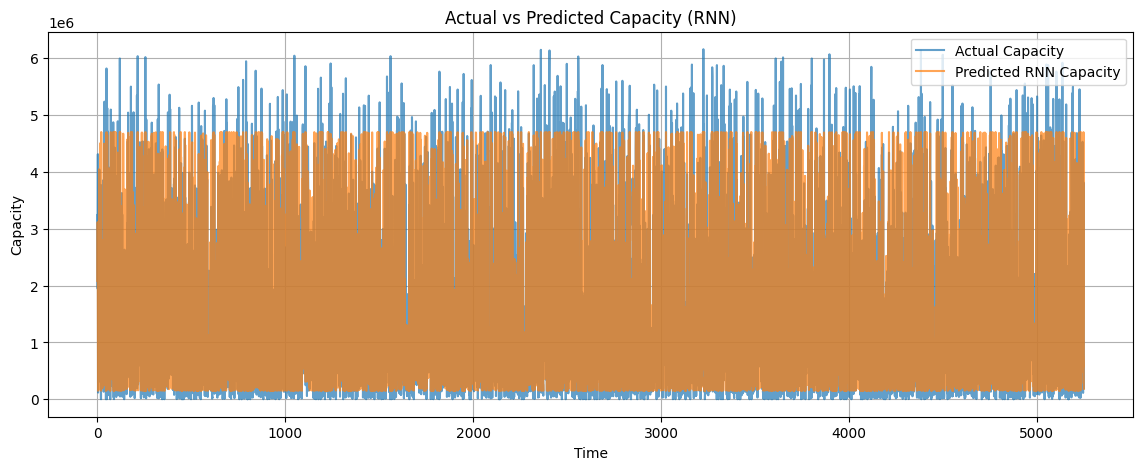

In [181]:
# Plot Predictions vs Actual Values for RNN
plt.figure(figsize=(14, 5))
plt.plot(actual_capacity, label='Actual Capacity', alpha=0.7)
plt.plot(predicted_capacity, label='Predicted RNN Capacity', alpha=0.7)
plt.title('Actual vs Predicted Capacity (RNN)')
plt.xlabel('Time')
plt.ylabel('Capacity')
plt.legend()
plt.grid(True)
plt.show()

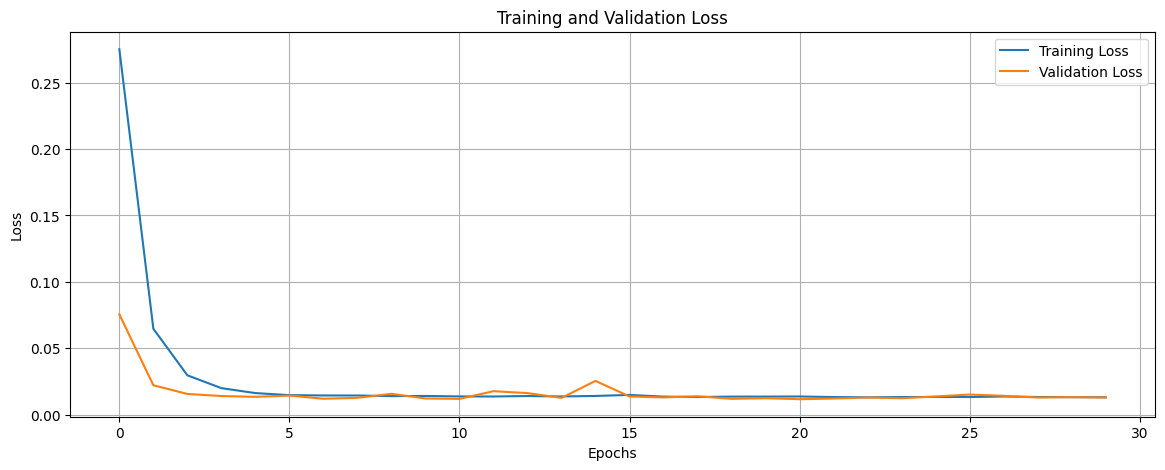

In [182]:
# Plot training history
plt.figure(figsize=(14, 5))
plt.plot(final_history.history['loss'], label='Training Loss')
plt.plot(final_history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()